# Pixmo Vision-Text Alignment with 4096-dim Embeddings

This notebook demonstrates the improved alignment training with:
1. **Pixmo Parquet Dataset** with embedded image bytes
2. **4096-dim embeddings** with MRL dimensions [2048, 1024, 512, 256, 128]
3. **Learnable attention pooling** instead of CLS/mean pooling
4. **Updated loss weights**: MRL=1.0, CLIP=0.25
5. **Text dropout** for better image reliance
6. **Improved training** with warmup+cosine LR, checkpointing, crash recovery
7. **Comprehensive logging** and visualization

**Hardware Requirements:**
- 1-2 H200 GPUs
- ~40-50GB GPU memory per GPU

## 1. Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / "src"))
Path.cwd().parent / "src"

PosixPath('/storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular/src')

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import wandb
from datetime import datetime

In [4]:
# Import our modules
from config import load_config
from models import MultimodalAlignmentModel
from data.dataset_builder import build_image_datasets_from_parquet
from data.transforms import get_image_transforms
from training.improved_trainer import ImprovedMultimodalTrainer
from utils.visualization import TrainingVisualizer

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [5]:
# Set up matplotlib
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch version: 2.9.0+cu128
CUDA available: True
GPU: NVIDIA H200
GPU Memory: 150.11 GB


## 2. Load Configuration

In [6]:
# Load experiment configuration
config_path = "../configs/pixmo_alignment.yaml"
config = load_config(config_path)

In [7]:
print(f"Experiment: {config.name}")
print(f"\nDataset Configuration:")
print(f"  Train Parquet: {config.dataset.train_parquet}")
print(f"  Val Parquet: {config.dataset.val_parquet}")
print(f"  Batch Size: {config.dataset.batch_size}")
print(f"  Text Dropout: {config.dataset.text_dropout_prob}")

print(f"\nModel Configuration:")
print(f"  Vision Encoder: {config.vision_encoder.model_name}")
print(f"  Projection Dim: {config.vision_encoder.projection_dim}")
print(f"  MRL Dimensions: {config.vision_encoder.mrl_dimensions}")
print(f"  Attention Pooling: {config.vision_encoder.use_attention_pooling}")
print(f"  Pooling Type: {config.vision_encoder.pooling_type}")

print(f"\nLoss Configuration:")
print(f"  CLIP Weight: {config.losses.contrastive}")
print(f"  MRL Weight: {config.losses.mrl}")
print(f"  Sample Single MRL Dim: {config.losses.sample_single_mrl_dim}")

print(f"\nOptimization Configuration:")
print(f"  Learning Rate: {config.optimization.lr}")
print(f"  Weight Decay: {config.optimization.weight_decay}")
print(f"  Max Grad Norm: {config.optimization.max_grad_norm}")
print(f"  Warmup Ratio: {config.optimization.warmup_ratio}")

Experiment: pixmo_vision_text_alignment

Dataset Configuration:
  Train Parquet: /home/hice1/vchopra37/scratch/projects/edge_glass/dataset/final_dataset/pixmo/pixmo_train.parquet
  Val Parquet: /home/hice1/vchopra37/scratch/projects/edge_glass/dataset/final_dataset/pixmo/pixmo_val.parquet
  Batch Size: 128
  Text Dropout: 0.1

Model Configuration:
  Vision Encoder: openai/clip-vit-large-patch14-336
  Projection Dim: 4096
  MRL Dimensions: [2048, 1024, 512, 256, 128]
  Attention Pooling: True
  Pooling Type: simple

Loss Configuration:
  CLIP Weight: 0.25
  MRL Weight: 1.0
  Sample Single MRL Dim: True

Optimization Configuration:
  Learning Rate: 0.0002
  Weight Decay: 0.01
  Max Grad Norm: 1.0
  Warmup Ratio: 0.1


## 3. Create Model

In [8]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create model
print("\nCreating multimodal alignment model with 4096-dim embeddings...")
model = MultimodalAlignmentModel(config)
model = model.to(device)

# Print parameter counts
print("\n" + "="*60)
model.print_parameter_counts()
print("="*60)

Using device: cuda

Creating multimodal alignment model with 4096-dim embeddings...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

trainable params: 40,370,176 || all params: 7,655,986,688 || trainable%: 0.5273

Component                            Trainable           Total
------------------------------------------------------------
Vision Encoder                       4,214,785     307,722,241
Text Encoder                         3,149,824     112,636,288
Decoder                             40,370,176   7,655,986,688
------------------------------------------------------------
TOTAL                              987,324,417   9,015,934,849


## 4. Load Pixmo Parquet Dataset

In [9]:
# Get image transforms
train_transforms = get_image_transforms(
    image_size=config.dataset.image_size,
    is_training=True
)

val_transforms = get_image_transforms(
    image_size=config.dataset.image_size,
    is_training=False
)

# Build datasets from parquet files
print("Loading Pixmo datasets from parquet files...")
datasets = build_image_datasets_from_parquet(
    cfg=config,
    train_parquet_path=config.dataset.train_parquet,
    val_parquet_path=config.dataset.val_parquet,
    test_parquet_path=config.dataset.test_parquet,
    train_transforms=train_transforms,
    val_transforms=val_transforms,
    max_text_length=config.dataset.max_text_length,
    text_dropout_prob=config.dataset.text_dropout_prob,
)

train_dataset = datasets['train']
val_dataset = datasets['val']

print(f"\nTrain samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
if 'test' in datasets:
    print(f"Test samples: {len(datasets['test'])}")

Loading Pixmo datasets from parquet files...


/storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular/src/data/dataset_builder.py:153: UserWarning: Removed 88 invalid images from /home/hice1/vchopra37/scratch/projects/edge_glass/dataset/final_dataset/pixmo/pixmo_train.parquet. Downstream loaders will skip them.
  warnings.warn(
/storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular/src/data/dataset_builder.py:153: UserWarning: Removed 16 invalid images from /home/hice1/vchopra37/scratch/projects/edge_glass/dataset/final_dataset/pixmo/pixmo_val.parquet. Downstream loaders will skip them.
  warnings.warn(



Train samples: 13912
Validation samples: 2984
Test samples: 2980


/storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular/src/data/dataset_builder.py:153: UserWarning: Removed 20 invalid images from /home/hice1/vchopra37/scratch/projects/edge_glass/dataset/final_dataset/pixmo/pixmo_test.parquet. Downstream loaders will skip them.
  warnings.warn(


In [10]:
# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.dataset.batch_size,
    shuffle=True,
    num_workers=config.dataset.num_workers,
    pin_memory=config.dataset.pin_memory,
    persistent_workers=config.dataset.persistent_workers if config.dataset.num_workers > 0 else False,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.dataset.batch_size,
    shuffle=False,
    num_workers=config.dataset.num_workers,
    pin_memory=config.dataset.pin_memory,
)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Train batches: 109
Validation batches: 24


## 5. Visualize Sample Data

In [11]:
# from datasets import load_dataset

# PIXMO_PARQUET_PATH = config.dataset.train_parquet
# print(f"\nPixMo-Cap Parquet Path: {PIXMO_PARQUET_PATH}")

# if Path(PIXMO_PARQUET_PATH).exists():
#     print("\n🔎 Verifying PixMo-Cap Parquet...")
#     pixmo_local = load_dataset(
#         "parquet", data_files={"train": str(PIXMO_PARQUET_PATH)}
#     )
#     print(pixmo_local)
#     print("Columns:", pixmo_local["train"].column_names)
#     print("Example row:", {k: str(v)[:80] for k, v in pixmo_local["train"][0].items()})


/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Batch keys: dict_keys(['image', 'text', 'sample_id'])
Image tensor shape: torch.Size([128, 3, 336, 336])
Number of captions: 128


/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


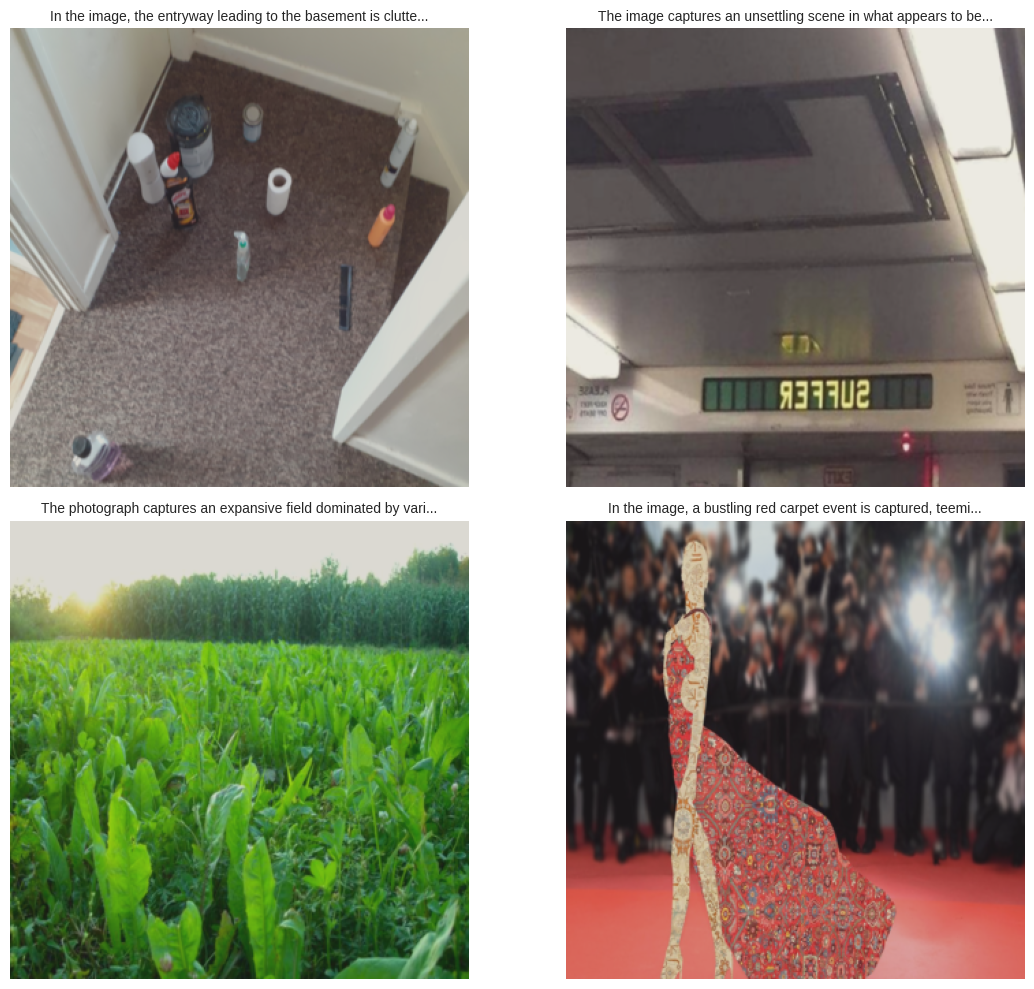


Note: Some captions may show '[DROPPED TEXT]' due to text dropout.


/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (130382142 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (161569818 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (100000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warni

In [12]:
# Get a sample batch
sample_batch = next(iter(train_loader))
print(f"Batch keys: {sample_batch.keys()}")
print(f"Image tensor shape: {sample_batch['image'].shape}")
print(f"Number of captions: {len(sample_batch['text'])}")

# Visualize first 4 images with captions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx in range(min(4, len(sample_batch['image']))):
    # Denormalize image
    img = sample_batch['image'][idx].cpu()
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img = torch.clamp(img, 0, 1)
    img = img.permute(1, 2, 0).numpy()
    
    axes[idx].imshow(img)
    caption_text = sample_batch['text'][idx] if sample_batch['text'][idx] else "[DROPPED TEXT]"
    axes[idx].set_title(caption_text[:60] + "...", fontsize=10)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("\nNote: Some captions may show '[DROPPED TEXT]' due to text dropout.")

## 6. Initialize Trainer

In [13]:
# Initialize trainer with improved features
use_wandb = True  # Set to True if you want to use WandB

trainer = ImprovedMultimodalTrainer(
    cfg=config,
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    use_wandb=use_wandb,
)

print("\nTrainer initialized with:")
print(f"  Checkpoint directory: {trainer.ckpt_dir}")
print(f"  Effective batch size: {trainer.effective_batch_size}")
print(f"  World size (GPUs): {trainer.world_size}")
print(f"  Starting epoch: {trainer.state.epoch}")
print(f"  Starting step: {trainer.state.global_step}")
print(f"  Best val loss: {trainer.state.best_val_loss}")

[2025-12-04 13:17:52][WARNING] DDP requested but no distributed process group found. Falling back to single-process training. Launch with torchrun to enable DDP.
109 10 1
[2025-12-04 13:17:52][INFO] Loading checkpoint from checkpoints/pixmo_alignment/checkpoint_latest.pt


/storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular/src/training/improved_trainer.py:109: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=cfg.optimization.fp16 or cfg.optimization.bf16)


[2025-12-04 13:18:04][INFO] Resumed from epoch 9, step 1199


wandb: Currently logged in as: vedaangchopra (vedaangchopra_gatech) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



Trainer initialized with:
  Checkpoint directory: checkpoints/pixmo_alignment
  Effective batch size: 128
  World size (GPUs): 1
  Starting epoch: 9
  Starting step: 1199
  Best val loss: 0.0


## 7. Train the Model

In [14]:
print("\nStarting training...")
print("="*60)

# Train
history = trainer.train()

print("\n" + "="*60)
print("Training completed!")
print(f"Best validation loss: {trainer.state.best_val_loss:.4f}")
print("="*60)


Starting training...
[2025-12-04 13:18:13][INFO] Starting training...
[2025-12-04 13:18:13][INFO] Epochs: 10
[2025-12-04 13:18:13][INFO] Steps per epoch: 109
[2025-12-04 13:18:13][INFO] Total training steps: 1090
[2025-12-04 13:18:13][INFO] Effective batch size: 128
[2025-12-04 13:18:13][INFO] 
Epoch 10/10


/storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular/src/training/improved_trainer.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.cfg.optimization.fp16 or self.cfg.optimization.bf16):


[2025-12-04 13:21:23][INFO] Train - Total: 1.1140, CLIP: 0.8983, MRL: 0.8894


/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[2025-12-04 13:22:04][INFO] Val - Total: 0.7646, CLIP: 0.6110, MRL: 0.6118
[2025-12-04 13:22:04][INFO]   R@1: 56.87%, R@5: 81.90%, R@10: 89.18%
[2025-12-04 13:22:27][INFO] Saved latest checkpoint to checkpoints/pixmo_alignment/checkpoint_latest.pt
[2025-12-04 13:22:27][INFO] Saved training history to checkpoints/pixmo_alignment/training_history.json
[2025-12-04 13:22:27][INFO] 
Training completed!
[2025-12-04 13:22:27][INFO] Best validation loss: 0.0000


epoch,▁
train/epoch,▁▁▁▁▁▁
train/loss,▆█▇▁▁█
train/loss_clip,▅█▆▁▂▆
train/loss_mrl,▆▇▇▁▁█
train/lr,▁▁▂▄▆█
train/step,▁▂▄▅▇█
val/i2t_r1,▁
val/i2t_r10,▁
val/i2t_r5,▁
+3,...



Training completed!
Best validation loss: 0.0000


## 8. Visualize Training Results

Training curves saved to outputs/pixmo_alignment/training_curves.png
Loss components saved to outputs/pixmo_alignment/loss_components.png
LR schedule saved to outputs/pixmo_alignment/lr_schedule.png


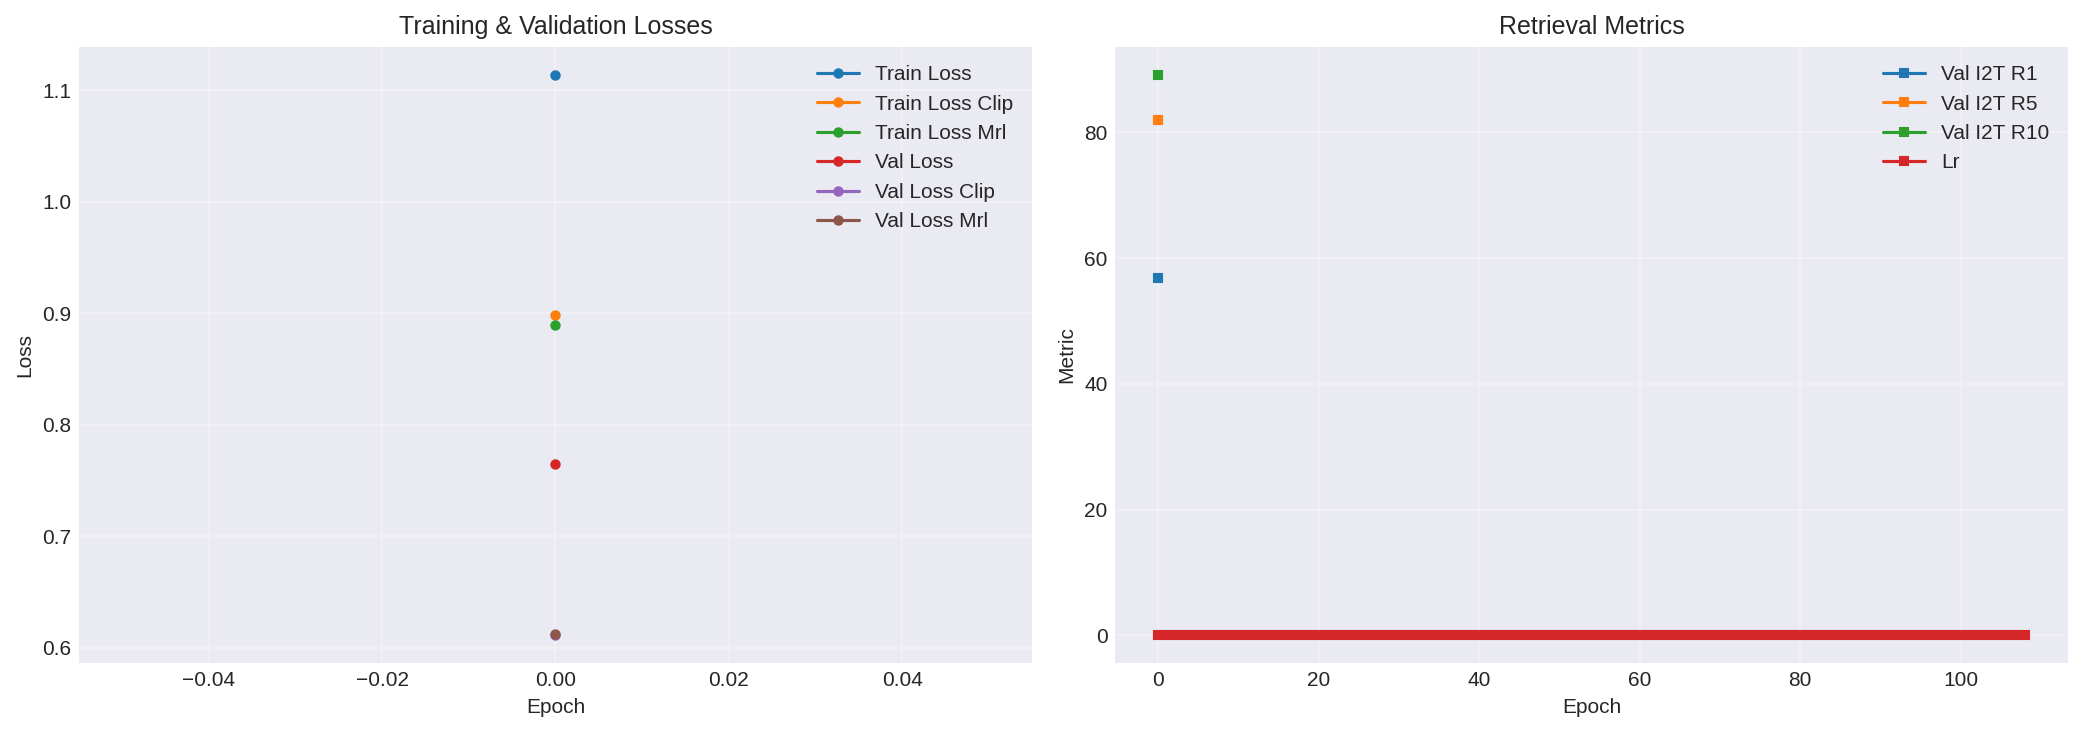

In [15]:
# Initialize visualizer
output_dir = Path(config.trainer.output_dir)
output_dir.mkdir(parents=True, exist_ok=True)
visualizer = TrainingVisualizer(save_dir=output_dir)

# Plot training curves
visualizer.plot_training_curves(history)
print(f"Training curves saved to {output_dir / 'training_curves.png'}")

# Plot loss components
visualizer.plot_loss_components(history)
print(f"Loss components saved to {output_dir / 'loss_components.png'}")

# Plot LR schedule
if history['lr']:
    visualizer.plot_lr_schedule(history['lr'])
    print(f"LR schedule saved to {output_dir / 'lr_schedule.png'}")

# Display training curves
from IPython.display import Image as IPImage, display
display(IPImage(filename=str(output_dir / 'training_curves.png')))

## 9. Evaluate and Visualize Embeddings

In [16]:
# Load best model
best_checkpoint_path = trainer.ckpt_dir / "checkpoint_best.pt"
if best_checkpoint_path.exists():
    checkpoint = torch.load(best_checkpoint_path, map_location=device, weights_only=False)
    model_to_load = model.module if isinstance(model, torch.nn.parallel.DistributedDataParallel) else model
    model_to_load.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from {best_checkpoint_path}")
    print(f"Best epoch: {checkpoint['epoch']}")
    print(f"Best val loss: {checkpoint['best_val_loss']:.4f}")
else:
    print("No best checkpoint found, using current model state.")

model.eval()

Loaded best model from checkpoints/pixmo_alignment/checkpoint_best.pt
Best epoch: 0
Best val loss: 0.0000


MultimodalAlignmentModel(
  (vision_encoder): VisionEncoder(
    (encoder): CLIPVisionModel(
      (vision_model): CLIPVisionTransformer(
        (embeddings): CLIPVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
          (position_embedding): Embedding(577, 1024)
        )
        (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (encoder): CLIPEncoder(
          (layers): ModuleList(
            (0-23): 24 x CLIPEncoderLayer(
              (self_attn): CLIPAttention(
                (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
              )
              (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
     

In [17]:
# Collect embeddings from validation set
print("Collecting embeddings for visualization...")
vision_embs = []
text_embs = []
captions = []

with torch.no_grad():
    for batch in tqdm(list(val_loader)[:10]):  # First 10 batches
        images = batch['image'].to(device)
        texts = batch['text']
        
        outputs = model(images=images, texts=texts, return_embeddings=True)
        
        vision_embs.append(outputs.vision_emb.cpu().numpy())
        text_embs.append(outputs.text_emb.cpu().numpy())
        captions.extend(texts)

vision_embs = np.vstack(vision_embs)
text_embs = np.vstack(text_embs)

print(f"Vision embeddings: {vision_embs.shape}")
print(f"Text embeddings: {text_embs.shape}")

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

Vision embeddings: (1280, 4096)
Text embeddings: (1280, 4096)


Embedding space saved to outputs/pixmo_alignment/embedding_space.png


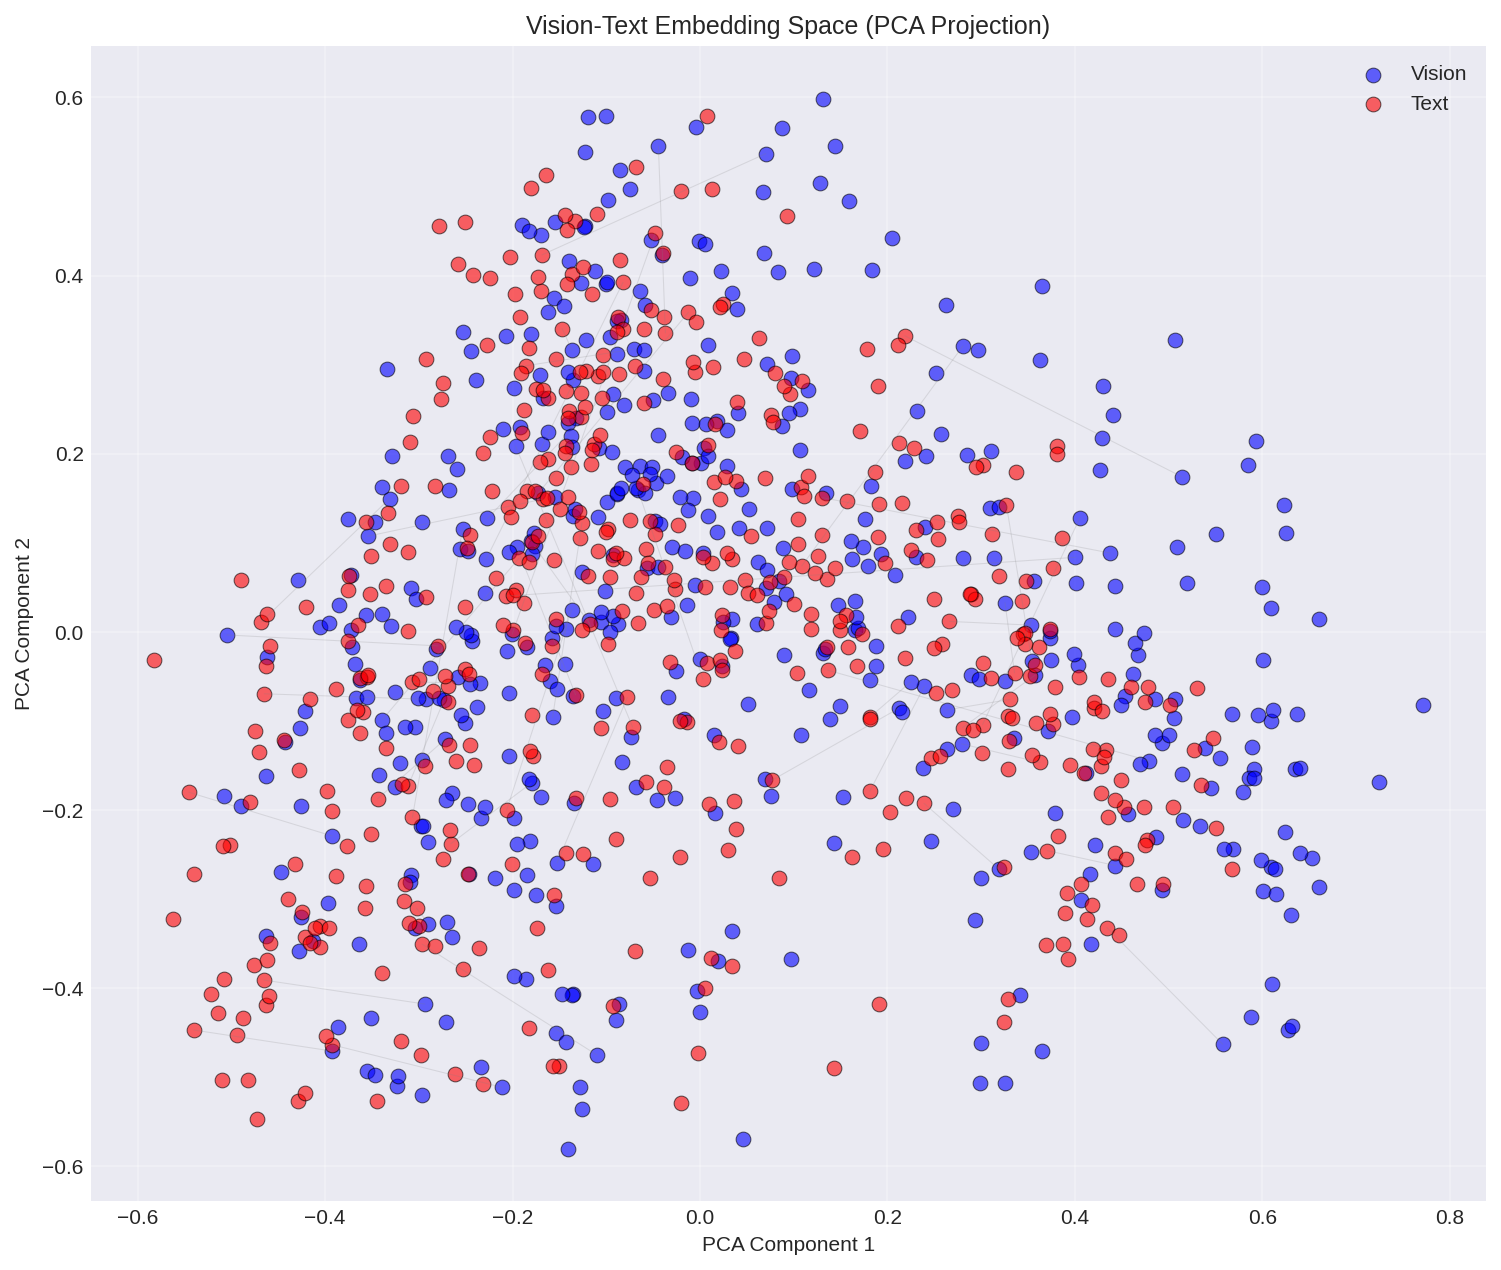

In [18]:
# Visualize embedding space
visualizer.plot_embedding_space(
    vision_embs=vision_embs,
    text_embs=text_embs,
    method="pca",
    n_samples=500,
)
print(f"Embedding space saved to {output_dir / 'embedding_space.png'}")

display(IPImage(filename=str(output_dir / 'embedding_space.png')))

Similarity matrix saved to outputs/pixmo_alignment/similarity_matrix.png


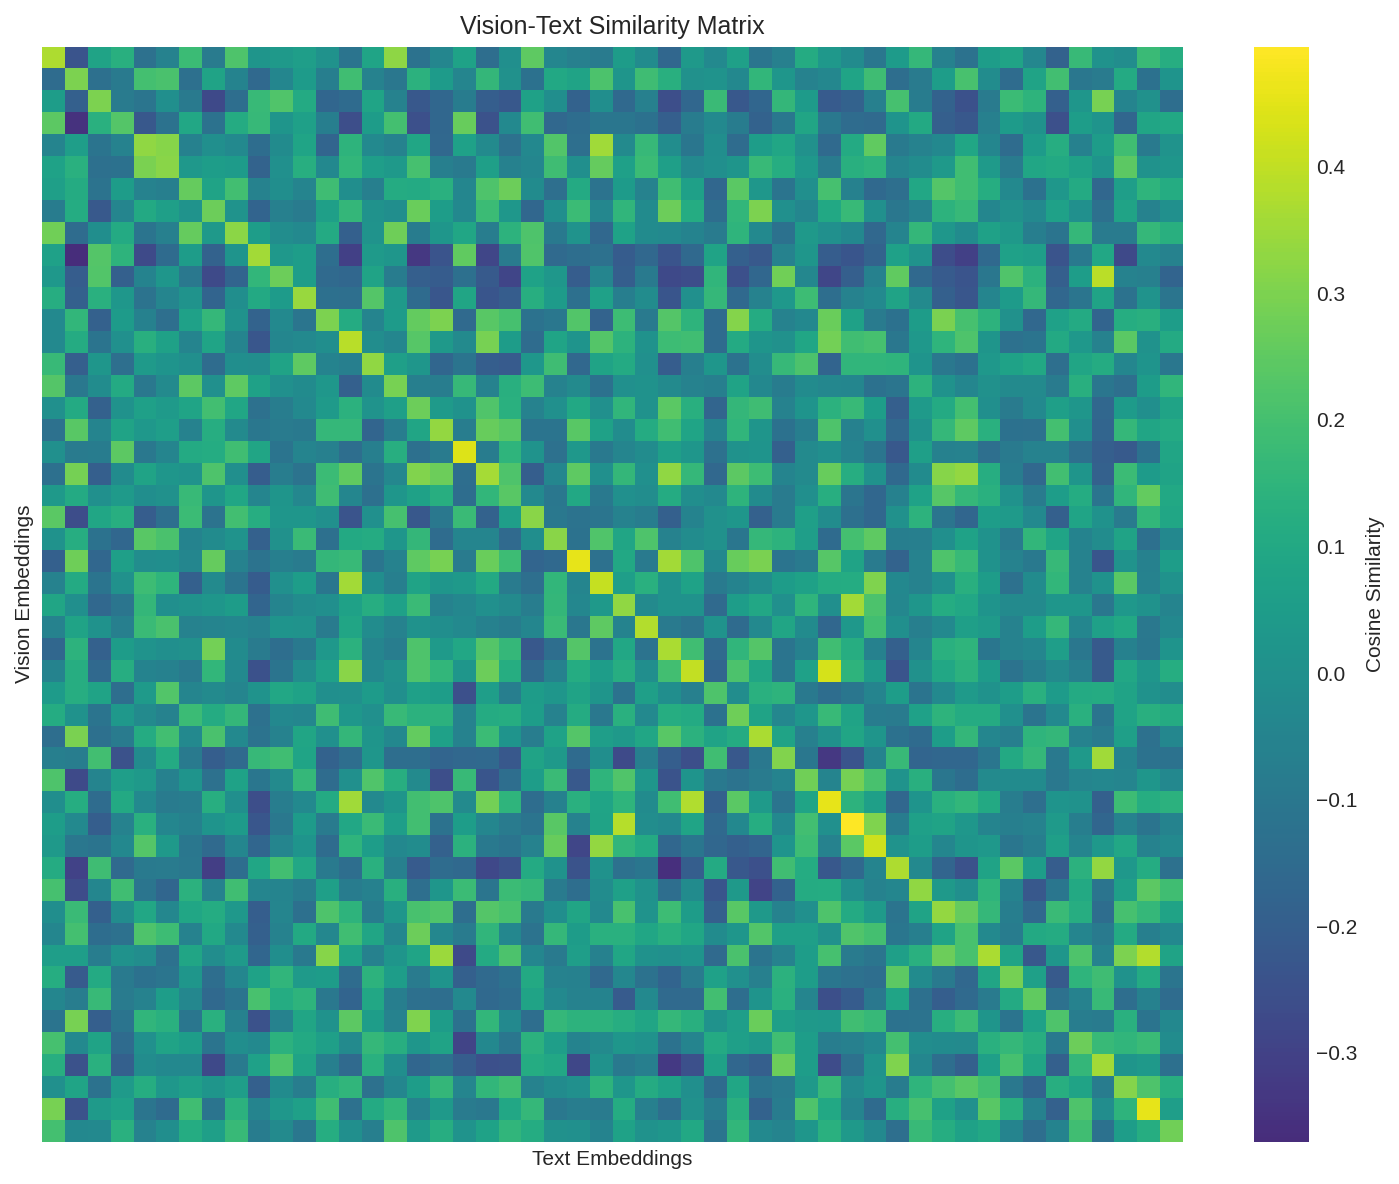

In [19]:
# Plot similarity matrix
visualizer.plot_similarity_matrix(
    vision_embs=vision_embs,
    text_embs=text_embs,
    n_samples=50,
)
print(f"Similarity matrix saved to {output_dir / 'similarity_matrix.png'}")

display(IPImage(filename=str(output_dir / 'similarity_matrix.png')))

## 10. MRL Dimension Accuracy Sweep


In [20]:
config.trainer

TrainerConfig(epochs=10, num_epochs=10, batch_size=128, save_every=20, log_every=20, ckpt_dir='./checkpoints/pixmo_alignment', output_dir='./outputs/pixmo_alignment', devices=2, strategy='ddp', use_wandb=True, wandb_project='edge_glass_alignment', wandb_run_name='pixmo_4096_mrl', retrieval_eval_samples=None, eval_batch_size=None, save_optimizer_state=True, best_weights_only=True)

EVAL SAMPLES: full validation set


/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Collected 2984 validation pairs for MRL accuracy sweep
Dim  128: Top-1 accuracy = 7.17%
Dim  256: Top-1 accuracy = 9.18%
Dim  512: Top-1 accuracy = 11.73%
Dim 1024: Top-1 accuracy = 14.51%
Dim 2048: Top-1 accuracy = 14.11%
Dim 4096: Top-1 accuracy = 14.31%


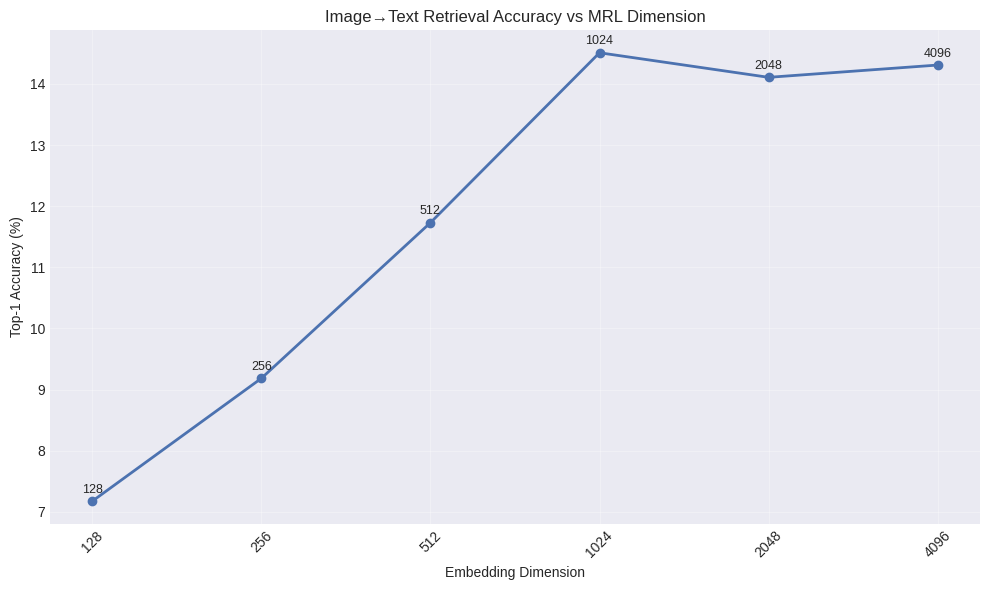

Accuracy plot saved to outputs/pixmo_alignment/mrl_dim_accuracy.png


In [22]:
# Sweep image->text top-1 accuracy across MRL embedding sizes
import torch.nn.functional as F

dims_to_test = sorted({config.vision_encoder.projection_dim, *config.vision_encoder.mrl_dimensions})
eval_samples_cfg = getattr(config.trainer, "retrieval_eval_samples", None)
eval_limit = eval_samples_cfg if isinstance(eval_samples_cfg, int) else None
print("EVAL SAMPLES:", eval_limit if eval_limit is not None else "full validation set")

val_vision_embs = []
val_text_embs = []
collected = 0

with torch.no_grad():
    for batch in val_loader:
        images = batch['image'].to(device)
        texts = batch['text']

        valid_indices = [i for i, t in enumerate(texts) if t]
        if not valid_indices:
            continue

        images = images[valid_indices]
        texts = [texts[i] for i in valid_indices]

        outputs = model(images=images, texts=texts, return_embeddings=True)
        val_vision_embs.append(outputs.vision_emb.cpu())
        val_text_embs.append(outputs.text_emb.cpu())

        collected += len(texts)
        if eval_limit is not None and collected >= eval_limit:
            break

if not val_vision_embs:
    print('No validation samples collected for MRL sweep.')
else:
    slice_limit = eval_limit if eval_limit is not None else None
    val_vision_embs = torch.cat(val_vision_embs, dim=0)[:slice_limit]
    val_text_embs = torch.cat(val_text_embs, dim=0)[:slice_limit]
    num_eval = val_vision_embs.shape[0]
    print(f'Collected {num_eval} validation pairs for MRL accuracy sweep')

    accuracy_by_dim = {}
    for dim in dims_to_test:
        vision_trunc = F.normalize(val_vision_embs[:, :dim], p=2, dim=-1)
        text_trunc = F.normalize(val_text_embs[:, :dim], p=2, dim=-1)
        sim = torch.matmul(vision_trunc, text_trunc.t())
        top1 = torch.argmax(sim, dim=1)
        acc = (top1 == torch.arange(num_eval)).float().mean().item() * 100
        accuracy_by_dim[dim] = acc
        print(f'Dim {dim:4d}: Top-1 accuracy = {acc:.2f}%')

    dims = list(accuracy_by_dim.keys())
    acc_values = [accuracy_by_dim[d] for d in dims]

    plt.figure(figsize=(10, 6))
    plt.plot(dims, acc_values, marker='o', linewidth=2, color='#4c72b0')
    plt.xlabel('Embedding Dimension')
    plt.ylabel('Top-1 Accuracy (%)')
    plt.title('Image→Text Retrieval Accuracy vs MRL Dimension')
    plt.xscale('log')
    plt.xticks(dims, [str(d) for d in dims], rotation=45)
    for d, a in zip(dims, acc_values):
        plt.annotate(str(d), (d, a), textcoords='offset points', xytext=(0, 6), ha='center', fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    acc_fig_path = Path(config.trainer.output_dir) / 'mrl_dim_accuracy.png'
    plt.savefig(acc_fig_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f'Accuracy plot saved to {acc_fig_path}')


## 11. Test Image Retrieval


In [23]:
# Test image-to-text retrieval
def retrieve_top_k(query_emb, database_embs, k=5):
    """Retrieve top-k nearest neighbors."""
    similarities = np.dot(database_embs, query_emb)
    top_indices = np.argsort(similarities)[::-1][:k]
    return top_indices, similarities[top_indices]

# Test on a few examples
n_examples = 3
for i in range(n_examples):
    print(f"\n{'='*60}")
    print(f"Example {i+1}:")
    print(f"Ground Truth Caption: {captions[i]}")
    
    # Image-to-text retrieval
    top_indices, scores = retrieve_top_k(vision_embs[i], text_embs, k=5)
    
    print("\nTop 5 Retrieved Captions:")
    for rank, (idx, score) in enumerate(zip(top_indices, scores), 1):
        match = "✓ MATCH" if idx == i else ""
        print(f"  {rank}. [{score:.3f}] {captions[idx][:80]}... {match}")


Example 1:
Ground Truth Caption: This detailed behind-the-scenes image features Robert Englund, the actor renowned for his role as Freddy Krueger in the 1984 horror classic "A Nightmare on Elm Street." Englund, a white man, commands the frame, donning Freddy's iconic red and black striped sweater and what looks like dungarees. He grips a mallet upside down in his left hand, with the mallet head pointing downward.

Of significant note is Englund's right hand, which is pressed to his chest and adorned with the infamous Freddy glove—a leather

Top 5 Retrieved Captions:
  1. [0.358] This detailed color photograph captures two men in character within a public res... 
  2. [0.356] This detailed, colorful portrait features a man resembling a famous actor, albei... 
  3. [0.353] A striking black and white graffiti-like artwork appears on a dilapidated, spall... 
  4. [0.346] In this whimsical holiday photograph, former First Lady Nancy Reagan is perched ... 
  5. [0.346] In this image, a pers

## 12. Summary and Key Metrics


In [24]:
print("\n" + "="*60)
print("EXPERIMENT SUMMARY")
print("="*60)

print(f"\nConfiguration:")
print(f"  Model: {config.name}")
print(f"  Vision Encoder: {config.vision_encoder.model_name}")
print(f"  Embedding Dimension: {config.vision_encoder.projection_dim}")
print(f"  MRL Dimensions: {config.vision_encoder.mrl_dimensions}")
print(f"  Attention Pooling: {config.vision_encoder.use_attention_pooling}")
print(f"  Text Dropout: {config.dataset.text_dropout_prob}")

print(f"\nLoss Weights:")
print(f"  CLIP Loss: {config.losses.contrastive}")
print(f"  MRL Loss: {config.losses.mrl}")

print(f"\nTraining:")
print(f"  Epochs: {config.trainer.epochs}")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")
print(f"  Best validation loss: {trainer.state.best_val_loss:.4f}")

if history['val_i2t_r1']:
    best_r1 = max(history['val_i2t_r1']) * 100
    best_r5 = max(history['val_i2t_r5']) * 100
    best_r10 = max(history['val_i2t_r10']) * 100
    print(f"  Best R@1: {best_r1:.2f}%")
    print(f"  Best R@5: {best_r5:.2f}%")
    print(f"  Best R@10: {best_r10:.2f}%")

print(f"\nModel Parameters:")
print(f"  Trainable: {model.num_trainable_parameters:,}")
print(f"  Total: {model.num_total_parameters:,}")
print(f"  Trainable %: {100*model.num_trainable_parameters/model.num_total_parameters:.2f}%")

print(f"\nOutput Files:")
print(f"  Best model: {trainer.ckpt_dir / 'checkpoint_best.pt'}")
print(f"  Latest checkpoint: {trainer.ckpt_dir / 'checkpoint_latest.pt'}")
print(f"  Training history: {trainer.ckpt_dir / 'training_history.json'}")
print(f"  Visualizations: {output_dir}")

print("\n" + "="*60)
print("Next Steps:")
print("="*60)
print("1. Evaluate on held-out test set")
print("2. Try different attention pooling strategies")
print("3. Fine-tune with decoder for instruction following")
print("4. Export model for deployment")
print("5. Benchmark latency/throughput for serving")
print("="*60)



EXPERIMENT SUMMARY

Configuration:
  Model: pixmo_vision_text_alignment
  Vision Encoder: openai/clip-vit-large-patch14-336
  Embedding Dimension: 4096
  MRL Dimensions: [2048, 1024, 512, 256, 128]
  Attention Pooling: True
  Text Dropout: 0.1

Loss Weights:
  CLIP Loss: 0.25
  MRL Loss: 1.0

Training:
  Epochs: 10
  Training samples: 13912
  Validation samples: 2984
  Best validation loss: 0.0000
  Best R@1: 56.87%
  Best R@5: 81.90%
  Best R@10: 89.18%

Model Parameters:
  Trainable: 987,324,417
  Total: 9,015,934,849
  Trainable %: 10.95%

Output Files:
  Best model: checkpoints/pixmo_alignment/checkpoint_best.pt
  Latest checkpoint: checkpoints/pixmo_alignment/checkpoint_latest.pt
  Training history: checkpoints/pixmo_alignment/training_history.json
  Visualizations: outputs/pixmo_alignment

Next Steps:
1. Evaluate on held-out test set
2. Try different attention pooling strategies
3. Fine-tune with decoder for instruction following
4. Export model for deployment
5. Benchmark laten

## 13. Save Final Metrics


In [25]:
# Save metrics table
if history['val_i2t_r1']:
    final_metrics = {
        'best_val_loss': trainer.state.best_val_loss,
        'best_r1': max(history['val_i2t_r1']),
        'best_r5': max(history['val_i2t_r5']),
        'best_r10': max(history['val_i2t_r10']),
        'final_train_loss': history['train_loss'][-1] if history['train_loss'] else 0,
        'final_val_loss': history['val_loss'][-1] if history['val_loss'] else 0,
        'embedding_dim': config.vision_encoder.projection_dim,
        'mrl_dims': str(config.vision_encoder.mrl_dimensions),
        'clip_weight': config.losses.contrastive,
        'mrl_weight': config.losses.mrl,
    }
    
    visualizer.save_metrics_table(final_metrics)
    print(f"Final metrics saved to {output_dir / 'metrics.csv'}")

print("\n✓ Notebook complete!")

Final metrics saved to outputs/pixmo_alignment/metrics.csv

✓ Notebook complete!
